# Pathfinder for Hidden connections 

#https://neo4j.com/docs/cypher-manual/current/introduction/uniqueness/ 
#https://stackoverflow.com/questions/14345555/return-unique-nodes-in-cypher-path-query
#https://github.com/neo4j/neo4j/issues/12628
#How to improve it to just get once Episode I: The Phantom Menace?

In [6]:
#Imports
from neo4j import GraphDatabase, basic_auth
import neo4jupyter
import pandas as pd
from vis_class import vis_class

In [7]:
#Create db connector
login = open("Login.txt", "r")
uri = login.readline().strip()
user = login.readline().strip()
password = login.readline().strip()
login.close()
#uri = "bolt://localhost:7687"
#user = "neo4j"
#password = "neo4j"

driver = GraphDatabase.driver(uri, auth=basic_auth(user, password))
session = driver.session(database="neo4j")
vis_class()

<IPython.core.display.Javascript object>

Vis class was created


## General Path finding / matching


Here we get an short overview how characters are connected over max. 5 diffrent relations

In [8]:
five_path = '''MATCH p = ()-[*5]-() RETURN nodes(p) Limit 5'''
results = session.read_transaction(
    lambda tx: tx.run(five_path).data())
results

[{'nodes(p)': [{'name': 'Episode I: The Phantom Menace'},
   {'name': 'JAR JAR'},
   {'name': 'JABBA'},
   {'name': 'FODE/BEED'},
   {'name': 'Episode I: The Phantom Menace'},
   {'name': 'BRAVO THREE'}]},
 {'nodes(p)': [{'name': 'Episode I: The Phantom Menace'},
   {'name': 'JAR JAR'},
   {'name': 'JABBA'},
   {'name': 'FODE/BEED'},
   {'name': 'Episode I: The Phantom Menace'},
   {'name': 'GREEDO'}]},
 {'nodes(p)': [{'name': 'Episode I: The Phantom Menace'},
   {'name': 'JAR JAR'},
   {'name': 'JABBA'},
   {'name': 'FODE/BEED'},
   {'name': 'Episode I: The Phantom Menace'},
   {'name': 'OBI-WAN'}]},
 {'nodes(p)': [{'name': 'Episode I: The Phantom Menace'},
   {'name': 'JAR JAR'},
   {'name': 'JABBA'},
   {'name': 'FODE/BEED'},
   {'name': 'Episode I: The Phantom Menace'},
   {'name': 'EMPEROR'}]},
 {'nodes(p)': [{'name': 'Episode I: The Phantom Menace'},
   {'name': 'JAR JAR'},
   {'name': 'JABBA'},
   {'name': 'FODE/BEED'},
   {'name': 'Episode I: The Phantom Menace'},
   {'name': '

## Finding hidden path

Here we will find the connections (hidden path) between two nodes to see how the Star Wars Universe is connected. Sometimes we have multiple minimal path as we see later.

In [18]:
# Paths between unconnected Person - Movie (Max 4 relations per path)
person_movie = '''match searchPath=(ms:Movie)<-[*..4]->(ps:Person) 
                    WHERE ms.name="Episode II: Attack of the Clones" AND ps.name="KI-ADI-MUNDI" 
                    return DISTINCT searchPath Limit 5'''

results = session.read_transaction(
    lambda tx: tx.run(person_movie).data())
results[:3]

[{'searchPath': [{'name': 'Episode II: Attack of the Clones'},
   'APPEARS_IN',
   {'name': 'SIO BIBBLE'},
   'SPEAKS_WITH',
   {'name': 'JAR JAR'},
   'APPEARS_IN',
   {'name': 'Episode I: The Phantom Menace'},
   'APPEARS_IN',
   {'name': 'KI-ADI-MUNDI'}]},
 {'searchPath': [{'name': 'Episode II: Attack of the Clones'},
   'APPEARS_IN',
   {'name': 'SIO BIBBLE'},
   'SPEAKS_WITH',
   {'name': 'JAR JAR'},
   'SPEAKS_WITH',
   {'name': 'MACE WINDU'},
   'SPEAKS_WITH',
   {'name': 'KI-ADI-MUNDI'}]},
 {'searchPath': [{'name': 'Episode II: Attack of the Clones'},
   'APPEARS_IN',
   {'name': 'SIO BIBBLE'},
   'SPEAKS_WITH',
   {'name': 'JAR JAR'},
   'SPEAKS_WITH',
   {'name': 'EMPEROR'},
   'SPEAKS_WITH',
   {'name': 'KI-ADI-MUNDI'}]}]

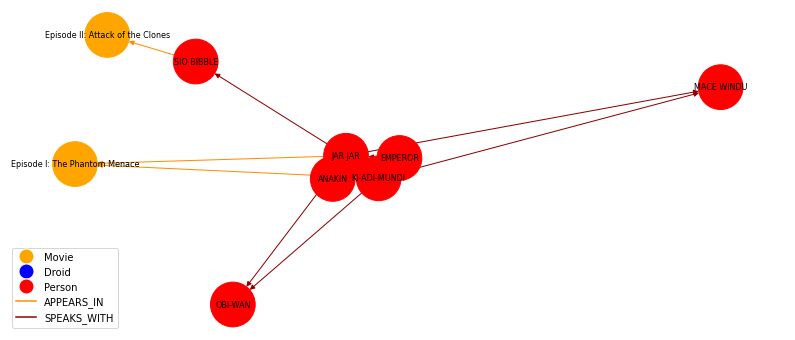

In [19]:
vis_class.power_drawGraph(driver, person_movie, font_size=8, width=14, height=6)

In [20]:
# Shortest path between unconnected Person - Movie (Max 4 relations per path)
# subquery to find the shortest and then query to get the one with the shortest length
person_movie = '''
    CALL {
        match p=(ms:Movie)<-[*..4]->(ps:Person)
        WHERE ms.name="Episode IV: A New Hope" AND ps.name="KI-ADI-MUNDI"
        return min(length(p)) AS shortest
    }
    MATCH searchPath=(ms:Movie)<-[*..4]->(ps:Person)
    WHERE ms.name="Episode IV: A New Hope" AND ps.name="KI-ADI-MUNDI" AND length(searchPath) = shortest
    return searchPath
'''
results = session.read_transaction(
    lambda tx: tx.run(person_movie).data())
results

[{'searchPath': [{'name': 'Episode IV: A New Hope'},
   'APPEARS_IN',
   {'name': 'OBI-WAN'},
   'SPEAKS_WITH',
   {'name': 'KI-ADI-MUNDI'}]}]

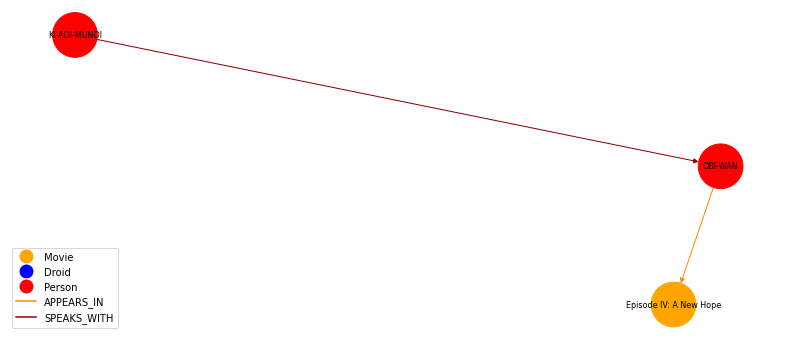

In [21]:
vis_class.power_drawGraph(driver, person_movie, font_size=8, width=14, height=6)

In [24]:
#Find path between Person and Person which are not related at the first glance
person_person = '''match searchPath=(p:Person)<-[*..4]->(ps:Person) 
                    WHERE p.name="JOBAL" AND ps.name="LANDO"
                    return DISTINCT searchPath Limit 5'''

results = session.read_transaction(
    lambda tx: tx.run(person_person).data())
results[:3]

[{'searchPath': [{'name': 'JOBAL'},
   'APPEARS_IN',
   {'name': 'Episode II: Attack of the Clones'},
   'APPEARS_IN',
   {'name': 'C-3PO'},
   'APPEARS_IN',
   {'name': 'Episode VI: Return of the Jedi'},
   'APPEARS_IN',
   {'name': 'LANDO'}]},
 {'searchPath': [{'name': 'JOBAL'},
   'APPEARS_IN',
   {'name': 'Episode II: Attack of the Clones'},
   'APPEARS_IN',
   {'name': 'C-3PO'},
   'SPEAKS_WITH',
   {'name': 'CHEWBACCA'},
   'SPEAKS_WITH',
   {'name': 'LANDO'}]},
 {'searchPath': [{'name': 'JOBAL'},
   'APPEARS_IN',
   {'name': 'Episode II: Attack of the Clones'},
   'APPEARS_IN',
   {'name': 'C-3PO'},
   'SPEAKS_WITH',
   {'name': 'MON MOTHMA'},
   'SPEAKS_WITH',
   {'name': 'LANDO'}]}]

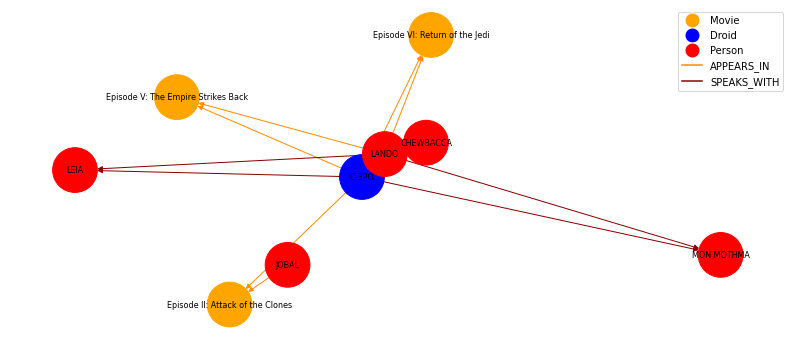

In [25]:
vis_class.power_drawGraph(driver, person_person, font_size=8, width=14, height=6)

In [31]:
person_person = '''
    CALL {
        match p=(p1:Person)<-[*..4]->(ps:Person)
        WHERE p1.name="JOBAL" AND ps.name="LANDO"
        return min(length(p)) AS shortest
    }
    MATCH searchPath=(p1:Person)<-[*..4]->(ps:Person)
    WHERE p1.name="JOBAL" AND ps.name="LANDO" AND length(searchPath) = shortest
    return searchPath
    Limit 2
'''
result =session.read_transaction(
    lambda tx: tx.run(person_person).data())
result

[{'searchPath': [{'name': 'JOBAL'},
   'APPEARS_IN',
   {'name': 'Episode II: Attack of the Clones'},
   'APPEARS_IN',
   {'name': 'C-3PO'},
   'SPEAKS_WITH',
   {'name': 'LANDO'}]},
 {'searchPath': [{'name': 'JOBAL'},
   'APPEARS_IN',
   {'name': 'Episode II: Attack of the Clones'},
   'APPEARS_IN',
   {'name': 'BOBA FETT'},
   'SPEAKS_WITH',
   {'name': 'LANDO'}]}]

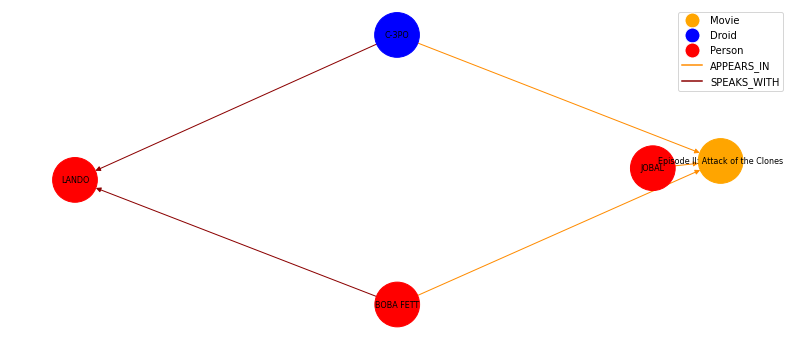

In [32]:
vis_class.power_drawGraph(driver, person_person, font_size=8, width=14, height=6)

In [ ]:
#Find path between Movie and Movie which are not related at the first glance
movie_movie = '''match searchPath=(ms:Movie)<-[*..4]->(ps:Person) 
                    WHERE ms.name="Episode II: Attack of the Clones" AND ps.name="KI-ADI-MUNDI" 
                    return DISTINCT searchPath'''

df = pd.DataFrame(session.read_transaction(
        lambda tx: tx.run(movie_movie).data()))
df.head()

In [ ]:
movie_movie = '''
    CALL {
        match p=(ms:Movie)<-[*..4]->(ps:Person)
        WHERE ms.name="Episode IV: A New Hope" AND ps.name="KI-ADI-MUNDI"
        return min(length(p)) AS shortest
    }
    MATCH searchPath=(ms:Movie)<-[*..4]->(ps:Person)
    WHERE ms.name="Episode IV: A New Hope" AND ps.name="KI-ADI-MUNDI" AND length(searchPath) = shortest
    return searchPath
'''
df = pd.DataFrame(session.read_transaction(
    lambda tx: tx.run(movie_movie).data()))
df.head()

## Closing the connection to the database

In [ ]:
#Close all connections
driver.close()
session.close()
drive = None
session = None